In [1]:
import sys  # system-specific parameters and functions
import os, glob  # operating system and file system utilities
import numpy as np  # numerical computing library
import matplotlib.pyplot as plt  # plotting library
import torch  # machine learning framework
import torch.nn.functional as F  # torch neural network functional API
from torchvision import transforms  # image transformations for computer vision
from torch.utils.data import Dataset  # dataset class for loading data
from torch.utils.data import DataLoader  # data loader for batching data
from PIL import Image  # Python Imaging Library for image processing

In [2]:
# Set the device to use for computations (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imbikramsaha/caltech-101")

print("Path to dataset files:", path)

c:\Users\voutl\OneDrive\Documents\Projects\Adversarial-Machine-Learning-Attacks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\voutl\.cache\kagglehub\datasets\imbikramsaha\caltech-101\versions\1


In [4]:
#load the model from the pytorch hub
target_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
target_model.eval()

# put the model on a GPU if available, otherwise CPU
target_model.to(device);

# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

with open("../data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

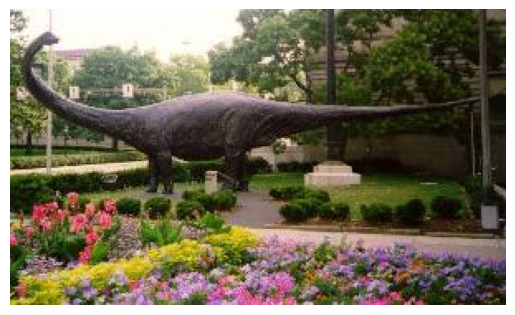

In [5]:
# load an example image
img = Image.open("C:/Users/voutl/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1/caltech-101/brontosaurus/image_0001.jpg")

plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
# preprocess the image
img_tensor = preprocess(img).unsqueeze(0)

# move sample to the right device
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = target_model(img_tensor)

label_index = torch.argmax(output)
    
print(f"Pred Index:\n---------------\n{label_index}\n")
print(f"Pred Label:\n---------------\n{labels[label_index]}\n")

Pred Index:
---------------
51

Pred Label:
---------------
triceratops



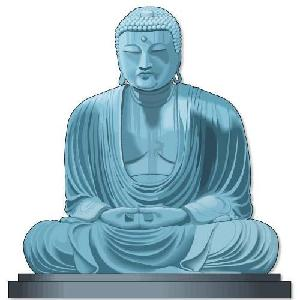

Predicted Label: oxygen mask


In [7]:
test_img_path = "C:/Users/voutl/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1/caltech-101/buddha/image_0008.jpg"
test_img = Image.open(test_img_path)
display(test_img)
test_img = preprocess(test_img).unsqueeze(0).to(device)
with torch.no_grad():
    label_index = torch.argmax(target_model(test_img))
print("Predicted Label: {}".format(labels[label_index]))

In [8]:
# Define a custom dataset class for image extraction
class ExtractionDataset(Dataset):
    def __init__(self, target_model, data_dir, transform=None):
        # Initialize the dataset with the target model, data directory, and optional transform
        self.target_model = target_model  # the model used for extraction
        self.data_dir = data_dir  # the directory containing the image data
        self.transform = transform  # optional transform to apply to images
        self.image_filenames = glob.glob(data_dir + "**/*.jpg")  # list of image file paths
        self.label_cache = dict()  # cache for storing labels

    def __len__(self):
        # Return the number of imags in the dataset
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Getter for a single image and its corresponding label
        image_path = self.image_filenames[idx]  # get the image file path
        image = Image.open(image_path).convert('RGB')  # open the image and convert to RGB
        
        if self.transform:
            # Apply the transform to the image if provided
            img_tensor = self.transform(image).unsqueeze(0)  # transform and add batch dimension
            
            with torch.no_grad():
                # Run the image through the target model to get the output (label)
                output = self.target_model(img_tensor.to(device)).argmax(1)
        
        # squeeze it back for batching
        img_tensor = img_tensor.squeeze(0)
        
        return img_tensor, output  # return the image tensor and its corresponding label

# create the dataset
dataset = ExtractionDataset(target_model, "C:/Users/voutl/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1/caltech-101/", preprocess)

In [9]:
print("number of samples", len(dataset))
print("sample image shape",dataset[0][0].shape)
print("sample output shape",dataset[0][1].shape)

number of samples 9144
sample image shape torch.Size([3, 224, 224])
sample output shape torch.Size([1])


In [10]:
query_budget = 5000

# get a bunch of images
permutation = torch.randperm(len(dataset))

# respect our query budget
train_idx = permutation[:query_budget]
eval_idx = permutation[query_budget:]

# create subsets
train_dataset = torch.utils.data.Subset(dataset, train_idx)
eval_dataset = torch.utils.data.Subset(dataset, eval_idx)

In [11]:
# DO NOT CHANGE
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True, verbose=False);

# explicitly set it to train mode vs eval
efficientnet.train()

# move it to the correct device
efficientnet.to(device);

c:\Users\voutl\OneDrive\Documents\Projects\Adversarial-Machine-Learning-Attacks\.venv\Lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to C:\Users\voutl/.cache\torch\hub\torchhub.zip
C:\Users\voutl/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [13]:
# Initialize the optimizer for the efficientnet model
# using the Adamax algorithm with a learning rate of 1e-3
optimizer = torch.optim.Adamax(efficientnet.parameters(), lr=1e-3)

# Initialize the loss function for the model
# using the Cross-Entropy Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Initialize a list to store the epoch loss history
epoch_loss_hist = []

# Train the model for 5 epochs
for epoch in range(5):
    # Iterate over training data
    for x, y in train_dataloader:
        # Move input and label tensors to the device (GPU or CPU)
        x = x.to(device)
        y = y.to(device)
        
        # Zero the gradients of the model parameters so they are unaffected by the previous iteration
        optimizer.zero_grad()
        
        # Forward pass: get the output for input x
        yhat = efficientnet(x)
        
        # Calculate loss between the model's output and the true label
        loss = loss_fn(yhat, y.view(-1))
        
        # Backward pass: compute the gradients of the loss
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Store the current loss value in the loss history
        epoch_loss_hist.append(loss.detach().cpu().item())
        
        # Print the current epoch, step, and mean loss to the console
        sys.stdout.write("\r Epoch: {:3.0f}  Step: {:3.0f}  Mean loss: {:4.4f}".format(epoch, len(epoch_loss_hist), np.mean(epoch_loss_hist)))
        sys.stdout.flush()
    print()

 Epoch:   0  Step: 157  Mean loss: 1.9721
 Epoch:   1  Step: 314  Mean loss: 1.3595
 Epoch:   2  Step: 471  Mean loss: 1.0194
 Epoch:   3  Step: 628  Mean loss: 0.8084
 Epoch:   4  Step: 785  Mean loss: 0.6673


In [14]:
from torch.utils.data import DataLoader

# create a DataLoader for your evaluation dataset
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# put model in evaluation mode
efficientnet.eval()

# initialize lists to store labels and predictions
true_labels = []
preds = []

for data, label in eval_dataloader:
    data = data.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        output = efficientnet(data).argmax(1)

    # store labels and predictions on the GPU. Remember CPU->GPU->CPU is slooowww
    true_labels.append(label)
    preds.append(output)

# concatenate all tensors on the GPU
true_labels = torch.cat(true_labels)
preds = torch.cat(preds)

# accuracy
accuracy = (true_labels == preds).float().sum() / len(true_labels)

print(f"Accuracy:\n---------------\n{accuracy.item():.2f}\n")

Accuracy:
---------------
61.92



In [16]:
img_path = "C:/Users/voutl/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1/caltech-101/dollar_bill/image_0013.jpg"
img = Image.open(img_path)

img_tensor = preprocess(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

target_output = target_model(img_tensor)
target_score = torch.softmax(target_output, dim=1)[0][target_output[0].argmax()].item()

copycat_output = efficientnet(img_tensor)
cc_score = torch.softmax(copycat_output, dim=1)[0][copycat_output[0].argmax()].item()


print(f"Target output index:\n---------------\n{target_output[0].argmax().item()}\n")
print(f"Copycat output index:\n---------------\n{copycat_output[0].argmax().item()}\n")

print(f"Target output probs:\n---------------\n{target_score*100:.2f}%\n")
print(f"Copycat output probs:\n---------------\n{cc_score*100:.2f}%\n")

Target output index:
---------------
481

Copycat output index:
---------------
692

Target output probs:
---------------
3.72%

Copycat output probs:
---------------
71.88%



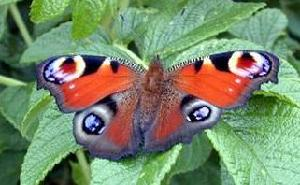

Predicted Label: ringlet


In [32]:
test_img_path = "C:/Users/voutl/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1/caltech-101/butterfly/image_0030.jpg"
test_img = Image.open(test_img_path)
display(test_img)
test_img = preprocess(test_img).unsqueeze(0).to(device)
with torch.no_grad():
    label_index = torch.argmax(target_model(test_img))
print("Predicted Label: {}".format(labels[label_index]))

In [17]:
def loss(output, mask, target_index, l2_weight):
    # Now we're removing the negative, we want it to be classified as the target_index
    classification_loss = torch.nn.functional.cross_entropy(output, target_index)
    
    # this says "No single pixel should be big, and the total magnitude of all of them should be small"
    l2_loss = torch.pow(mask, 2).sum()
    
    total_loss =  classification_loss+(l2_weight * l2_loss)
    
    # Now we penalize large distortions a bit less.
    return total_loss, classification_loss, l2_loss

In [18]:
# brontasauras..or bronta-sauras?
img = Image.open("C:/Users/voutl/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1/caltech-101/brontosaurus/image_0001.jpg")
img_tensor = preprocess(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

# airplane
tgt = Image.open("C:/Users/voutl/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1/caltech-101/airplanes/image_0001.jpg")
tgt_tensor = preprocess(tgt).unsqueeze(0)
tgt_tensor = tgt_tensor.to(device)

In [19]:
# create the mask
mask = torch.randn_like(img_tensor)*1e-3
mask_parameter = torch.nn.Parameter(mask.to(device))

# create the optimizer
adv_optimizer = torch.optim.Adam([mask_parameter])

target_index = target_model(tgt_tensor)[0].argmax().unsqueeze(0).to(device)
copy_cat_index = efficientnet(tgt_tensor)[0].argmax().unsqueeze(0).to(device)

# print(copy_cat_index, target_index)

l2_weight = 0.5
step = 0

while True: # evaluate it until the prediction matches the target label
    output = efficientnet(img_tensor+mask_parameter)
    total_loss, class_loss, l2_loss = loss(output, mask_parameter, target_index, l2_weight)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    step+=1
    
    sys.stdout.write(f"\rStep: {step}  total loss: {total_loss.item():4.4f}    class loss:{class_loss.item():4.4f}     l2 loss: {l2_loss.item():4.4f}   Predicted class index:{output[0].argmax()}");
    sys.stdout.flush()
    
    if output[0].argmax().item() == target_index.item():
        break
        
print(f"\n\nWinner winner: {labels[output[0].argmax().item()]}")

Step: 3  total loss: 0.8283    class loss:0.7529     l2 loss: 0.1508   Predicted class index:895

Winner winner: warplane


In [20]:
final_out = target_model(img_tensor + mask_parameter)

print(f"Offline class index:\n---------------\n{output[0].argmax().item()}\n")
print(f"Online class index:\n---------------\n{final_out[0].argmax().item()}\n")

Offline class index:
---------------
895

Online class index:
---------------
51

